## DSAN5650 Midterm

The following cell just runs an external file called `jupyter_fixes.ipynb`, which should have also been copied into your "Midterm" folder -- it applies a few changes that are required e.g. to prevent `matplotlib`'s warning about caching!

In [1]:
%run jupyter_fixes.ipynb

## [Part 1: Social Science] Modeling Social Phenomena with PGMs: The Selective Transmission of Historical Documents

### Loading and Exploring the Data

This question is going to feel a bit "in the weeds" at first -- because it is -- but points to the importance of the [library of missing datasets](https://github.com/MimiOnuoha/missing-datasets) which lurks behind any actually-existing dataset you may find! It also relates to Berkson's Paradox, which will be the subject of Part 2 below.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patchworklib as pw;
import pymc as pm

In [7]:
pub_url = "https://raw.githubusercontent.com/jpowerj/dsan-content/refs/heads/main/2025-sum-dsan5650/cahiers_official.csv"
pub_df = pd.read_csv(pub_url)
pub_df.head()

,village_name,published,huguenot
0,ARRAS (ARTOIS),True,False
1,"AURAY, REUNI A VANNES (SEN)",True,False
2,AUTUN,True,True
3,"BOULAY, REUNI A SARREGUEMINES",True,True
4,CALAIS,True,False


As the following cell shows, there were 32 villages whose *cahiers* were deemed "exemplary" of the grievances of France as a whole:

In [4]:
len(pub_df)

32

And, as the following cell makes clear, over 40% of these "exemplary" *cahiers* contained grievances about the treatment of French Protestants (Huguenots):

In [5]:
pub_df['huguenot'].value_counts(normalize=True)

huguenot
False    0.59375
True     0.40625
Name: proportion, dtype: float64

### [Question 1.1] Modeling the Published Documents

In the following code cell, use PyMC to create a generative model of the published *cahiers* as follows:

* First, the model should include a variable `p_hug`, representing the overall probability that a given *cahier* contains a grievance related to treatment of Huguenots
* Then, the model should include a *village-specific* variable `huguenot`, a binary variable which has the value 1 for villages whose cahier contains a grievance related to treatment of Huguenots, and 0 for villages whose cahier does not contain such a grievance.

`p_hug` and `huguenot` should be **linked** such that the probability of `huguenot` taking the value 1 is exactly `p_hug` -- the included line of code at the end of the cell prints the model as a PGM, where there should be an arrow from the `p_hug` node to the `huguenot` node!

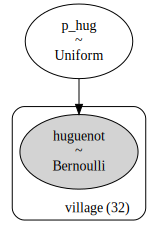

In [17]:
# @title Q1.1-response
village_idx, village_name = pub_df['village_name'].factorize()
hug_values = pub_df['huguenot']
coords = {'village': village_idx}
with pm.Model(coords=coords) as pub_model:
    # Your code here: model the two random variables p_hug and huguenot as
    # described above

    # overall prob of cahier contains grievance
    p_hug = pm.Uniform("p_hug", lower=0, upper=1)
        
    # village-specific binary variable for grievance
    huguenot = pm.Bernoulli("huguenot", p = p_hug, observed=hug_values, dims="village")
    
    #pass # Remove this pass statement once you've started coding your model!
if pub_model is not None:
    display(pm.model_to_graphviz(pub_model))

### [Question 1.2] Sampling from the Prior Distribution

Now, in the following code cell, sample from the **prior predictive** distribution using PyMC's `sample_prior_predictive()` function, storing the result in a variable named `pub_prior_idata`. Once this variable is created correctly, the remaining provided code will construct a Pandas `DataFrame` and plot the distribution of `p_hug`:

Sampling: [huguenot, p_hug]


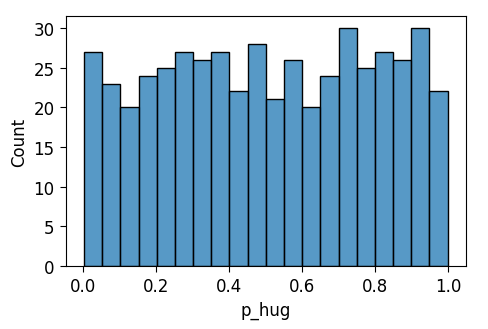

In [18]:
# @title Q1.2-response
# Your code here: create a variable pub_prior_idata containing the predictive prior
# distribution
with pub_model:
    pub_prior_idata = pm.sample_prior_predictive(random_seed=1296)
# Convert to DataFrame
pub_prior_df = pub_prior_idata.prior.to_dataframe().reset_index().drop(columns="chain")

# And plot
ax = pw.Brick(figsize=(4, 2.5));
sns.histplot(
    x="p_hug", data=pub_prior_df, binwidth=0.05, ax=ax
);
ax.savefig()

### Inferring the *Number* of *Cahiers* Containing Huguenot Grievances

If the above code worked as intended, the following code cell should just take the `pub_prior_idata` variable you created and use it to infer the **number** of published cahiers (out of the 32 total that were chosen) containing Huguenot grievances (demonstrating how we can use your model to "jump" to a more coarse-grained level of "cahiers corpus" rather than just individual *cahiers*)

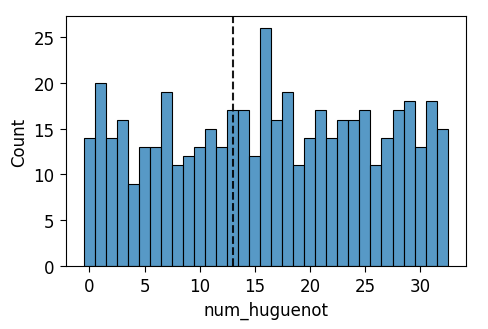

In [19]:
# @title Q1.2-infer-num-cahiers
pub_prior_pred_df = pub_prior_idata.prior_predictive.to_dataframe().reset_index().drop(columns="chain")
sum_df = pub_prior_pred_df.groupby('draw')['huguenot'].sum().to_frame().reset_index()
sum_df.rename(columns={'huguenot': 'num_huguenot'}, inplace=True)
true_num_hug = len(pub_df[pub_df['huguenot']])

ax = pw.Brick(figsize=(4,2.5));
sns.histplot(
    x="num_huguenot", data=sum_df, ax=ax,
    discrete=True
);
ax.axvline(x=true_num_hug, ls='dashed', color='black', alpha=0.9);
ax.savefig()

### [Question 1.3] Sampling from the Posterior Distribution

Now, let's **estimate** the model parameters using the actual data! In the following code cell, use `sample()` (rather than `sample_prior_predictive()` to draw the actual Bayesian-optimized parameter values, storing the result in a variable named `pub_post_idata`.

If sampled correctly, the plot of the posterior distribution of `p_hug` generated by the included code should be centered around the true value of about 0.4.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_hug]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


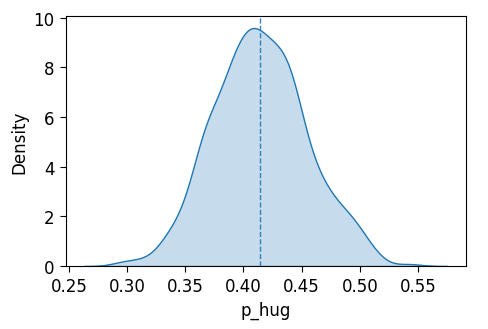

In [20]:
# @title Q1.3-response
# Your code here: use pm.sample() to estimate the *posterior* distribution from
# the data in pub_df
with pub_model:
    pub_post_idata = pm.sample(random_seed=1296)
# Convert to DataFrame
pub_post_df = pub_post_idata.posterior.to_dataframe().reset_index()
pub_post_df = pub_post_df.groupby('draw')['p_hug'].mean().to_frame()
# And plot
ax = pw.Brick(figsize=(4, 2.5));
sns.kdeplot(
    x="p_hug", data=pub_post_df, ax=ax,
    fill=True
);
ax.axvline(x=pub_post_df['p_hug'].mean(), lw=1, ls='dashed', alpha=0.9);
ax.savefig()

### [Question 1.4] Sampling from the Posterior Predictive Distribution

Now, drawing on the example code above which performed this coarse-graining on the **prior** predictive distribution (the code cell titled `Q1.2-infer-num-cahiers`), first use PyMC's `sample_posterior_predictive()` function to sample the model's posterior predictive distribution, then use it to generate a plot of the **posterior predictive** distribution of a variable you should name `num_huguenot`: the estimated **number** of *cahiers* mentioning Huguenot grievances given the learned parameters of your model.

In [ ]:
# @title Q1.4-response
with pub_model:
    pub_post_pred_idata = pm.sample_posterior_predictive(pub_post_idata, random_seed=5650)

In [ ]:
pub_post_pred_df = pub_post_pred_idata.posterior_predictive.to_dataframe().reset_index()
pub_post_pred_df = pub_post_pred_df[pub_post_pred_df['chain'] == 0].drop(columns="chain")
pub_post_pred_df

In [ ]:
post_sum_df = pub_post_pred_df.groupby('draw')['huguenot'].sum().to_frame().reset_index()
post_sum_df.rename(columns={'huguenot': 'num_huguenot'}, inplace=True)
post_sum_df

In [ ]:
true_num_hug = len(pub_df[pub_df['huguenot']])

ax = pw.Brick(figsize=(4,2.5));
sns.histplot(
    x="num_huguenot", data=post_sum_df, ax=ax,
    discrete=True
);
ax.axvline(x=true_num_hug, ls='dashed', color='black', alpha=0.9);
ax.savefig()

### [Question 1.5] Accounting for Bias

However, this is where **domain knowledge** can come into play. To condense a long story into a nice neat narrative for this exam (since this is not a class about the French Revolution!), here are four quick stylized facts:

1. A popular interpretation of the French Revolution argues that it was a "bourgeois revolution", meaning that it was in essence the seizure of power by budding capitalists away from the French monarchy.
2. For a bunch of reasons (like their connections with rich Germans who had adopted Protestantism centuries earlier), wealthy Huguenots were seen as possible "replacements" for the Catholic allies whom French Revolutionaries had alienated (e.g., by nationalizing all Church property and forcing Catholic priests to sign an oath of loyalty to the nation of France over Rome). However, many of them had fled in 
3. In addition to the ~700,000 Huguenots, there was a mass [influx of ~40,000 Protestants](https://en.wikipedia.org/wiki/Patriottentijd#Aftermath) from the Netherlands, who were also among the wealthy elites of that country.
4. There was a guy named [Jean-Paul Rabaut](https://en.wikipedia.org/wiki/Jean-Paul_Rabaut_Saint-%C3%89tienne) who you can think of as a "spokesman" for the Huguenot community of France during the crucial first 4 years of the French Revolution (until he was guillotined in 1793). Rabaut put Huguenot rights "on the agenda" as the **president** of the French National Assembly in 1790, and more generally could use his power to put Huguenot

These four facts put together hopefully help motivate the hypothesis that the French Revolutionaries -- especially those involved in shaping the "public image" of the Revolution -- had an interest in **emphasizing the freedom that Protestants now had**. Concretely, this led to the following law passed in December of 1790:

> All persons born in a foreign country and descending in any degree of a French man or woman **expatriated for religious reasons** are declared French nationals (naturels français) and will benefit from rights attached to that quality if they come back to France, establish their domicile there and take the civic oath.

And so, the hypothesis just becomes that: the same collection of people who organized around Huguenot rights to push laws like this into being, also pushed to ensure that **narratives of the French Revolution** such as those **embodied in document collections** would emphasize the Huguenot struggle as much as possible.

Given all this, your job in this part is to **model the possible bias in representation** arising from this push: rather than modeling the distribution $\Pr(\textsf{Huguenot})$ as **independent of** the distribution $\Pr(\textsf{Published})$, you should now model an **inflation factor** representing **how much the proportion of *published cahiers* mentioning Huguenots was inflated (or deflated!) relative to the total collection of *cahiers*.**

In other words, your new model should have a variable named `p_pub_nohug` representing the probability of a *cahier* being published given that it does **not** contain a Huguenot-related grievance, and a variable named `p_pub_hug` representing the probability of a *cahier* that **does** contain a Huguenot-related grievance is published. (If it helps, think about the HW2C problem where you estimated disaster rates before and after a given **change point** -- this problem should be a bit less complex than that, since you don't need to estimate a changepoint in this case, just two separate $\Pr(\textsf{Publish})$ distributions!)

Run the following code cell to load the data for **all** villages, then (a) use the prior-predictive distribution to generate plots of `p_pub_nohug` and `p_pub_hug`

In [23]:
full_url = "https://raw.githubusercontent.com/jpowerj/dsan-content/refs/heads/main/2025-sum-dsan5650/cahiers_all.csv"
full_df = pd.read_csv(full_url)
full_df.head()

,village_name,published,huguenot
0,ABBEVILLE,False,True
1,AGEN,False,False
2,AIX,False,False
3,ALENCON,False,False
4,AMIENS,False,False


In [ ]:
len(full_df)

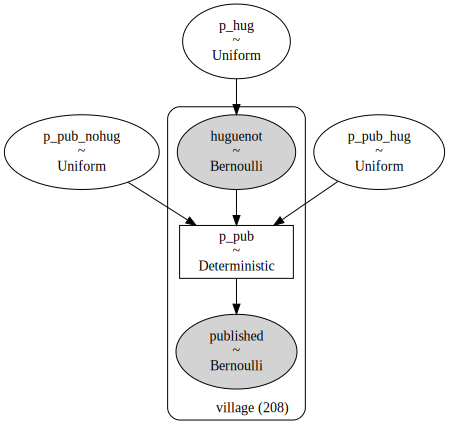

In [24]:
hug_values = full_df['huguenot']
pub_values = full_df['published']
village_idx, village_names = full_df['village_name'].factorize()
coords = {'village': village_idx}
with pm.Model(coords=coords) as infl_model:
    # Your code here: model the probability of publication p_pub *with* and
    # *without* a Huguenot-related grievance, as described above!
    p_pub_nohug = pm.Uniform("p_pub_nohug", lower = 0, upper = 0.5)
    p_pub_hug = pm.Uniform("p_pub_hug", lower = 0.3, upper = 1)

    p_hug = pm.Uniform("p_hug", lower=0, upper=1)

    huguenot = pm.Bernoulli("huguenot", p = p_hug, observed=hug_values, dims="village")

    p_pub = pm.Deterministic('p_pub', pm.math.switch(huguenot, p_pub_hug, p_pub_nohug), dims="village")
    
    published = pm.Bernoulli("published", p = p_pub, observed=pub_values, dims="village")
    
#     pass # Remove this pass statement once you've started coding your model!
if infl_model is not None:
    display(pm.model_to_graphviz(infl_model))

### [Question 1.6] The Prior Predictive Distribution for `p_pub_nohug` and `p_pub_hug`

As in the published-only case from earlier, derive and plot the prior predictive distributions for these two parameters here. Name the derived prior data `infl_prior_idata`.

Sampling: [huguenot, p_hug, p_pub_hug, p_pub_nohug, published]


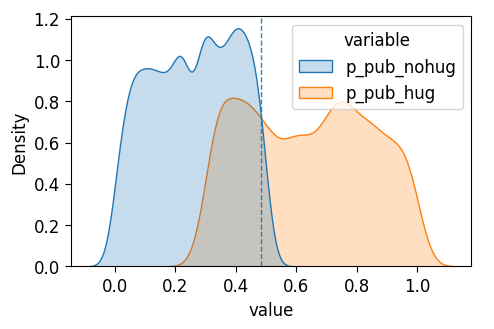

In [25]:
# Your code here: store the prior data for the model as infl_prior_idata
with infl_model:
    infl_prior_idata = pm.sample_prior_predictive(random_seed=1296)

# Convert to DataFrame
infl_prior_df = infl_prior_idata.prior.to_dataframe().reset_index().drop(columns='chain')
# Melt DataFrame to plot both p_pub_nohug and p_pub_hug within the same plot
infl_long_df = infl_prior_df[['draw','village','p_pub_nohug','p_pub_hug']].melt(id_vars=['draw','village'])
# And plot
ax = pw.Brick(figsize=(4, 2.5));
sns.kdeplot(
    x="value", hue="variable", data=infl_long_df, ax=ax,
    fill=True, bw_adjust=2,
);
ax.axvline(x=infl_prior_df['p_hug'].mean(), lw=1, ls='dashed', alpha=0.9);
ax.savefig()

### [Question 1.7] The Posterior Distribution

You made it to the final step! Here, use PyMC's `sample()` function to estimate the **posterior** distribution from the data in `full_df` loaded above, storing it in a variable named `infl_post_idata`:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_pub_nohug, p_pub_hug, p_hug]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


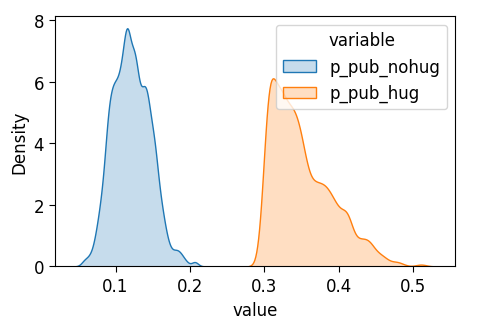

In [26]:
# @title Q1.7-response
# Your code here: estimate the *posterior* and store it in a variable named
# infl_post_idata
with infl_model:
    infl_post_idata = pm.sample(random_seed=1206)

# Convert to DataFrame
infl_post_df = infl_post_idata.posterior.to_dataframe().reset_index()
# Extract only the first chain
infl_post_df = infl_post_df[infl_post_df['chain'] == 0]
# Melt as before
infl_post_long_df = infl_post_df[['draw','village','p_pub_nohug','p_pub_hug']].melt(id_vars=['draw','village'])
# And plot!
ax = pw.Brick(figsize=(4, 2.5));
sns.kdeplot(
    x="value", hue="variable", data=infl_post_long_df, ax=ax,
    fill=True, bw_adjust=2,
);
ax.savefig()

## [Part 2: Causality] Identifying and Blocking Backdoor Paths I

### The PGM $\mathcal{G}_1$

For the context of this part, assume that you are a researcher studying the relationship between $X$ and $Y$. Your ultimate goal is to estimate the **direct effect** of $X$ on $Y$, but you've identified two possible **confounders** $Z_1$ and $Z_2$ that may impact the direct effect you're hoping to estimate (since the **total effect** of $X$ on $Y$, which you can estimate via e.g. regression, will be the **sum** of the direct effect $X \rightarrow Y$ and any indirect effects "flowing" through other paths from $X$ to $Y$).

For Questions 2.1 through 2.5, assume that you've modeled the relationships among the four variables via the following PGM $\mathcal{G}_1$:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/311db9ef8099d0d530693cda59eab127b0b87b57/2025-sum-dsan5650/pgm_1.svg" width="60%"></img>
<figcaption><i>The PGM $\mathcal{G}_1$ (for Questions 2.1-2.5)</i></figcaption>
</figure>
</center>

### [Question 2.1]

$\mathcal{G}_1$ has two paths from $X$ to $Y$, listed below. Which of them are **backdoor paths** from $X$ to $Y$? *(Check all that apply)*

* (a) $X \rightarrow Y$
* (b) $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$

In [ ]:
# @title Q2.1-response
q2_1a_response = False # Replace with True to "check" option (a)
q2_1b_response = True # Replace with True to "check" option (b)

### [Question 2.2]

With respect to the triple $X \leftarrow Z_1 \rightarrow Z_2$ within $\mathcal{G}_1$, the node $Z_1$ is a... *(Select one option)*

* (a) Fork
* (b) Pipe
* (c) Collider
* (d) Proxy

In [ ]:
# @title Q2.2-response
q2_2_response = "a" # Replace with e.g. "a" for option (a)

### [Question 2.3]

With respect to the triple $Z_1 \rightarrow Z_2 \rightarrow Y$ within $\mathcal{G}_1$, the node $Z_2$ is a... *(Select one option)*

* (a) Fork
* (b) Pipe
* (c) Collider
* (d) Proxy

In [ ]:
# @title Q2.3-response
q2_3_response = "b" # Replace with e.g. "a" for option (a)

### [Question 2.4]

Conditioning on $Z_1$ in $\mathcal{G}_1$ will... *(Select one option)*

* (a) Fully close the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (b) Fully open the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (c) Reduce the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%
* (d) Increase the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%

In [ ]:
# @title Q2.4-response
q2_4_response = "a" # Replace with e.g. "a" for option (a)

### [Question 2.5]

Conditioning on $Z_2$ in $\mathcal{G}_1$ will... *(Select one option)*

* (a) Fully close the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (b) Fully open the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (c) Reduce the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%
* (d) Increase the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%

In [ ]:
# @title Q2.5-response
q2_5_response = "a" # Replace with e.g. "a" for option (a)

### The PGM $\mathcal{G}_2$

For Questions 2.6 and 2.7, refer to the following PGM $\mathcal{G}_2$. Assume that the **correlation coefficient** between $Z_1$ and $A$ is **0.7** (i.e., if we know the value of $Z_1$, we can predict the value of $A$ with 70% accuracy, and vice-versa)

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/311db9ef8099d0d530693cda59eab127b0b87b57/2025-sum-dsan5650/pgm_2.svg" width="60%"></img>
<figcaption><i>The PGM $\mathcal{G}_2$ (for Questions 2.6 and 2.7)</i></figcaption>
</figure>
</center>

### [Question 2.6]

With respect to the triple $X \leftarrow Z_1 \rightarrow Z_2$ within $\mathcal{G}_2$, the node $A$ is a... *(Select one option)*

* (a) Fork
* (b) Pipe
* (c) Collider
* (d) Proxy

In [ ]:
# @title Q2.6-response
q2_6_response = "d" # Replace with e.g. "a" for option (a)

### [Question 2.7]

Conditioning on $A$ in $\mathcal{G}_2$ will... *(Select one option)*

* (a) Fully close the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (b) Fully open the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (c) Reduce the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%
* (d) Increase the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%

In [ ]:
# @title Q2.7-response
q2_7_response = "c" # Replace with e.g. "a" for option (a)

### The PGM $\mathcal{G}_3$

For Questions 2.8 and 2.9, refer to the following PGM $\mathcal{G}_3$ (which is the same as $\mathcal{G}_1$, but where the arrow between $Z_2$ and $Y$ has reversed direction!)

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/311db9ef8099d0d530693cda59eab127b0b87b57/2025-sum-dsan5650/pgm_3.svg" width="60%"></img>
<figcaption><i>The PGM $\mathcal{G}_3$ (for Questions 2.8 and 2.9)</i></figcaption>
</figure>
</center>

### [Question 2.8]

With respect to the triple $Z_1 \rightarrow Z_2 \leftarrow Y$ within $\mathcal{G}_3$, the node $Z_2$ is a... *(Select one option)*

* (a) Fork
* (b) Pipe
* (c) Collider
* (d) Proxy

In [ ]:
# @title Q2.8-response
q2_8_response = "c" # Replace with e.g. "a" for option (a)

### [Question 2.9]

Conditioning on $Z_2$ in $\mathcal{G}_3$ will... *(Select one option)*

* (a) Fully close the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (b) Fully open the path $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$
* (c) Reduce the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%
* (d) Increase the indirect effect of $X$ on $Y$ by way of $X \leftarrow Z_1 \rightarrow Z_2 \rightarrow Y$ by 70%

In [ ]:
# @title Q2.9-response
q2_9_response = "b" # Replae with e.g. "a" for option (a)

## [Part 3: Causality] One Observed Distribution, Three Possible DGPs

In this question, we first simulate the outcomes from three different DGPs. Your task is then to implement them as fully-fledged PyMC models, so that you can obtain **causal** effects using PyMC's `do()` function, rather than just the **conditional** effects that the basic simulations provide.

So, run through the following code cells, making sure you understand the workings of each DGP before you start on the cell titled `Q3.1a-response` below!

In [28]:
import pandas as pd
import numpy as np
rng = np.random.default_rng(seed=5650)
import matplotlib.pyplot as plt
import patchworklib as pw
import seaborn as sns

import pymc as pm
import arviz as az

N = 5000

### DGP 1

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/824a359a5758eeaae925a3fabe213139c18008e3/2025-sum-dsan5650/dgp_1.svg" width="30%"></img>
<figcaption><i>Graphical representation of the DGP $\mathcal{P}_1$ for Part 3</i></figcaption>
</figure>
</center>

<table>
<thead>
<tr>
    <th align="center" colspan="4">The DGP $\mathcal{P}_1$ for Part 3</th>
</tr>
<tr>
    <th>Step</th>
    <th colspan="3">Operation</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$X$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(0, 1)$</td>
</tr>
<tr>
    <td>2.</td>
    <td>$Y$</td>
    <td>$\leftarrow$</td>
    <td>$X + 1 + \sqrt{3} \cdot \varepsilon_Y$</td>
</tr>
</tbody>
</table>

where $\varepsilon_Y \sim \mathcal{N}(0, 1)$

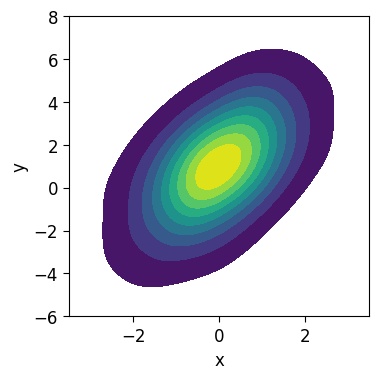

In [30]:
def plot_dgp_result(df):
    ax = pw.Brick(figsize=(3, 3));
    sns.kdeplot(
        x="x", y="y", fill=True, data=df, ax=ax,
        levels=10, cmap="viridis", bw_adjust=2
    );
    ax.set_xlim(-3.5, 3.5);
    ax.set_ylim(-6, 8);
    return ax

# Run DGP
x = rng.normal(size=N)
y_noise = rng.normal(size=N)
y = x + 1 + np.sqrt(3) * y_noise
# Collect results into a DataFrame
df1 = pd.DataFrame({'x': x, 'y': y, 'dgp': 1})
# And plot
ax1 = plot_dgp_result(df1)
ax1.savefig()

### DGP 2

In the second DGP, $Y$ is generated first, then $X$ is derived from $Y$:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/824a359a5758eeaae925a3fabe213139c18008e3/2025-sum-dsan5650/dgp_2.svg" width="30%"></img>
<figcaption><i>Graphical representation of the DGP $\mathcal{P}_2$ for Part 3</i></figcaption>
</figure>
</center>

<table>
<thead>
<tr>
    <th align="center" colspan="4">The DGP $\mathcal{P}_2$ for Part 3</th>
</tr>
<tr>
    <th>Step</th>
    <th colspan="3">Operation</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$Y$</td>
    <td>$\leftarrow$</td>
    <td>$\mathcal{N}(1, 2)$</td>
</tr>
<tr>
    <td>2.</td>
    <td>$X$</td>
    <td>$\leftarrow$</td>
    <td>$\frac{Y - 1}{4} + \frac{\sqrt{3}}{2} \cdot \varepsilon_X$</td>
</tr>
</tbody>
</table>

where $\varepsilon_X \sim \mathcal{N}(0, 1)$

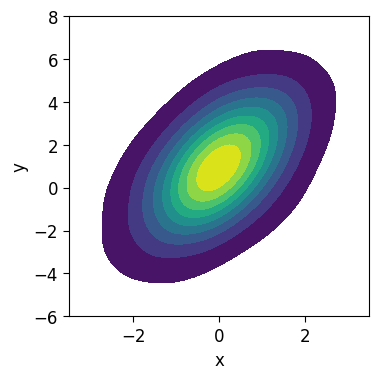

In [31]:
# Generate X and Y
y = rng.normal(1, 2, size=N)
x_noise = rng.normal(size=N)
x = (y - 1) / 4 + np.sqrt(3) * x_noise / 2
# Collect into a DataFrame
df2 = pd.DataFrame({'x': x, 'y': y, 'dgp': 2})
# And plot
ax2 = plot_dgp_result(df2)
ax2.savefig()

### DGP 3

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/824a359a5758eeaae925a3fabe213139c18008e3/2025-sum-dsan5650/dgp_3.svg" width="30%"></img>
<figcaption><i>Graphical representation of the DGP $\mathcal{P}_3$ for Part 3</i></figcaption>
</figure>
</center>

<table>
<thead>
<tr>
    <th align="center" colspan="4">The DGP $\mathcal{P}_3$ for Part 3</th>
</tr>
<tr>
    <th>Step</th>
    <th colspan="3">Operation</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$Z$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(0, 1)$</td>
</tr>
<tr>
    <td>2.</td>
    <td>$X$</td>
    <td>$\leftarrow$</td>
    <td>$Z$</td>
</tr>
<tr>
    <td>3.</td>
    <td>$Y$</td>
    <td>$\leftarrow$</td>
    <td>$Z + 1 + \sqrt{3} \cdot \varepsilon_Y$</td>
</tr>
</tbody>
</table>

where $\varepsilon_Y \sim \mathcal{N}(0, 1)$

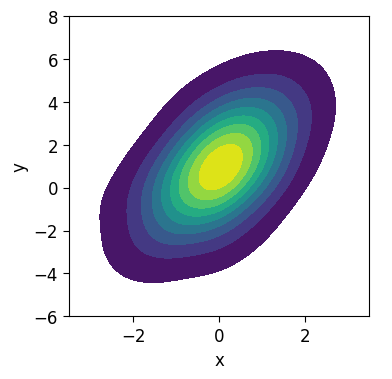

In [32]:
# Run DGP3
z = rng.normal(size=N)
x = z
y = z + 1 + np.sqrt(3) * rng.normal(size=N)
# Collect into a DataFrame
df3 = pd.DataFrame({'x': x, 'y': y, 'z': z, 'dgp': 3})
# And plot
ax3 = plot_dgp_result(df3)
ax3.savefig()

### Plotted Side-By-Side

The problem for us as [social] scientists, and the reason why we need to delve into the $\textsf{do}()$ operator, is because all three of these DGPs -- despite their very different **causal** underpinnings! -- result in exactly the same **observed** joint distribution $\Pr(X, Y)$, as we can see if we plot them side-by-side:

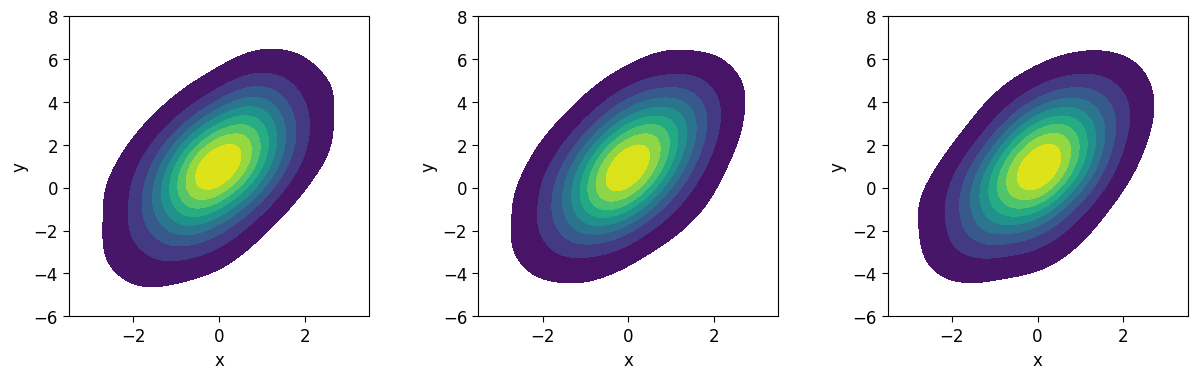

In [33]:
ax_all = ax1 | ax2 | ax3;
ax_all.savefig()

### Conditional Distributions

Now let's say we observe $X = 2$. Let's see, for each distribution, whether simply **conditioning on** this observation gives us the resulting **causal** impact of $X$ taking on the value 2!

Unfortunately, since $X$ is a continuous distribution, we won't get any observations by "scooping out" only rows with $X$ exactly equal to 2:

In [ ]:
df1[df1['x'] == 2.0]

So, instead, we'll define an "epsilon ball" $\varepsilon = 0.05$, and "scoop out" rows where $X$ is within $\epsilon$ of 2, for each of our three DGPs:

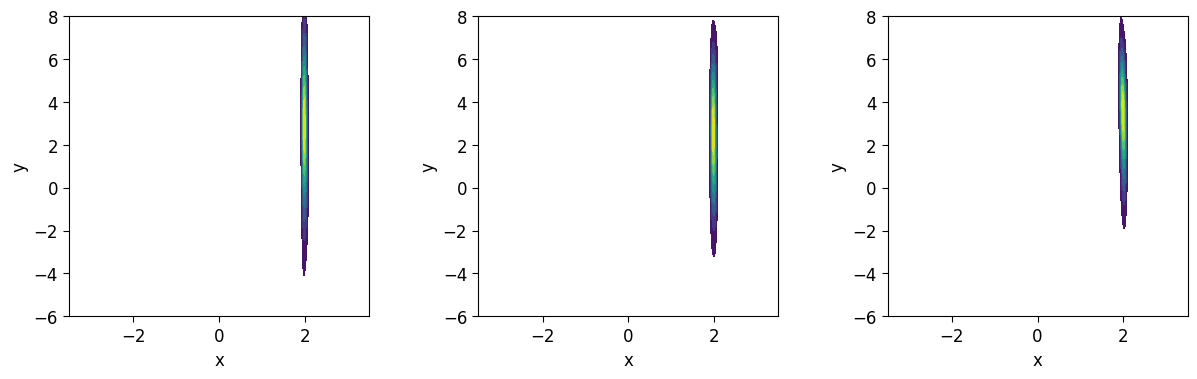

In [34]:
eps = 0.05
df1_obs = df1[(2.0 - eps < df1['x']) & (df1['x'] < 2.0 + eps)].copy()
df2_obs = df2[(2.0 - eps < df2['x']) & (df2['x'] < 2.0 + eps)].copy()
df3_obs = df3[(2.0 - eps < df3['x']) & (df3['x'] < 2.0 + eps)].copy()
ax1o = plot_dgp_result(df1_obs);
ax2o = plot_dgp_result(df2_obs);
ax3o = plot_dgp_result(df3_obs);
axo = ax1o | ax2o | ax3o;
axo.savefig()

This way of plotting helps to remind us that the joint distribution evaluated at $x \approx 2$, $f_{X,Y}(2, y)$, corresponds to a vertical "slice" from the full joint distribution $f_{X,Y}(x, y)$, but it isn't very helpful otherwise.

Instead, let's plot the **marginal** distribution $f_{Y}(y \mid x \approx 2)$ on its own (keeping in mind that, since we've **observed** $X$, the $x$-axis here represents possible values of $Y$ in the distribution! In other words, we're plotting the vertical "slice" from the above plot, but rotated 90° left)

In [35]:
df_all = pd.concat([df1, df2, df3])
df_all.head()

,x,y,dgp,z
0,-1.126471,-1.997546,1,NaN
1,-1.068890,-0.959638,1,NaN
2,-0.403220,0.197741,1,NaN
3,1.525297,0.380769,1,NaN
4,-0.265578,-0.336792,1,NaN


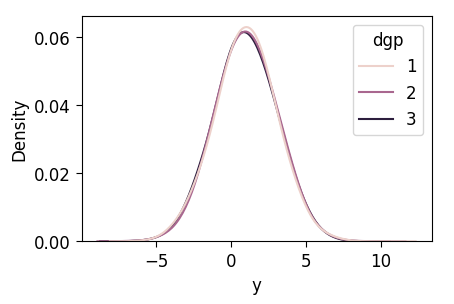

In [36]:
axo_all = pw.Brick(figsize=(3.5, 2.25));
sns.kdeplot(
    x="y", hue="dgp", data=df_all, ax=axo_all, bw_adjust=2
);
axo_all.savefig()

However, **we know something is wrong here**, in terms of capturing **causal** effects! We know, in particular, that "forcing" the value of $X$ to be 2 in $\mathcal{P}_1$ **should have a causal impact on $Y$**, which is not true of $\mathcal{P}_2$ or $\mathcal{P}_3$ where $X$ and $Y$ are independent.

So, your job is now to **use PyMC to implement these three DGPs as generative models**, then use PyMC's `do()` operator to obtain the **actual causal effect** that $X$ being forced to have the value 2 should have on $Y$, in terms of the conditional distribution $f_{Y}(y \mid x = 2)$, for each DGP.

### [Question 3.1a] $\mathcal{P}_1$ as a PyMC Model

As a reminder, the graphical representation of $\mathcal{P}_1$, along with its steps, are as follows:

<table>
<thead>
<tr>
    <th align="center" colspan="4">The DGP $\mathcal{P}_1$ for Part 3</th>
</tr>
<tr>
    <th>Step</th>
    <th colspan="3">Operation</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$X$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(0, 1)$</td>
</tr>
<tr>
    <td>2.</td>
    <td>$Y$</td>
    <td>$\leftarrow$</td>
    <td>$X + 1 + \sqrt{3} \cdot \varepsilon_Y$</td>
</tr>
</tbody>
</table>

where $\varepsilon_Y \sim \mathcal{N}(0, 1)$.

Implement this DGP as a PyMC model named `dgp1` in the following cell (where the code we've included at the end will display your DGP as a PGM):

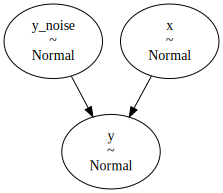

In [27]:
# @title Q3.1a-response
with pm.Model() as dgp1:
    # Your code here: implement a model linking variables named x,
    # y_noise (for the random noise term epsilon in Step 2), and y
    x = pm.Normal("x", mu=0, sigma=1)
    y_noise = pm.Normal("y_noise", mu=0, sigma=1)
    mu_y = x + 1 + np.sqrt(3) * y_noise
    y = pm.Normal("y", mu=mu_y, sigma=0.5)

#    pass # Remove this pass statement once you've started coding your model!

# Once your model is defined, the following lines will display the DGP as a PGM:
if dgp1 is not None:
    display(pm.model_to_graphviz(dgp1))

### [Question 3.1b] Prior Predictive Distribution for $\mathcal{P}_1$

Now, in the following cell, use the `sample_prior_predictive()` function from PyMC to draw a sample from `dgp1`, calling the resulting InferenceData object `dgp1_idata`.

In [37]:
# @title Q3.1b-response
# Your code here: create a dgp1_idata variable containing the predictive prior
# distribution as derived from the dgp1 model from Question 3.1a
with dgp1:
    dgp1_idata = pm.sample_prior_predictive(random_seed=1296)   

# The following lines will convert your sample into a Pandas DataFrame, then
# print the first five rows (so you can check that the result looks as expected)
dgp1_df = dgp1_idata.prior.to_dataframe().reset_index().drop(columns="chain")
dgp1_df.head()

Sampling: [x, y, y_noise]


,draw,y_noise,x,y
0,0,-0.770543,-0.964516,-1.545951
1,1,1.928018,-0.360234,3.245502
2,2,1.335803,0.516004,4.265261
3,3,-1.523320,0.532355,-2.151921
4,4,-0.130034,-0.245925,0.372164


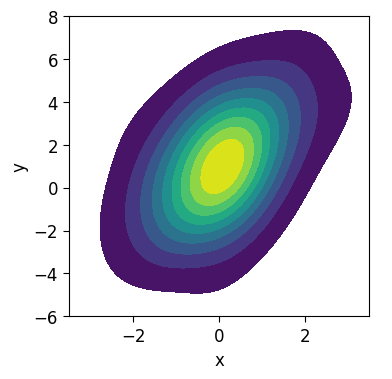

In [38]:
ax1_pymc = plot_dgp_result(dgp1_df)
ax1_pymc.savefig()

### [Question 3.2a] $\mathcal{P}_2$ as a PyMC Model

As a reminder, the graphical representation of $\mathcal{P}_2$, along with its steps, are as follows:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/824a359a5758eeaae925a3fabe213139c18008e3/2025-sum-dsan5650/dgp_2.svg" width="30%"></img>
<figcaption><i>Graphical representation of the DGP $\mathcal{P}_2$ for Part 3</i></figcaption>
</figure>
</center>

<table>
<thead>
<tr>
    <th align="center" colspan="4">The DGP $\mathcal{P}_2$ for Part 3</th>
</tr>
<tr>
    <th>Step</th>
    <th colspan="3">Operation</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td align="center">$Y$</td>
    <td align="center">$\sim$</td>
    <td>$\mathcal{N}(1, 2)$</td>
</tr>
<tr>
    <td>2.</td>
    <td>$X$</td>
    <td>$\leftarrow$</td>
    <td>$\frac{Y - 1}{4} + \frac{\sqrt{3}}{2} \cdot \varepsilon_X$</td>
</tr>
</tbody>
</table>

where $\varepsilon_X \sim \mathcal{N}(0, 1)$.


Implement this DGP as a PyMC model named `dgp2` in the following cell (where the code we've included at the end will display your DGP as a PGM):

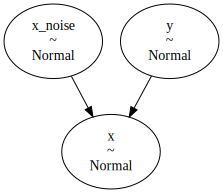

In [41]:
# @title Q3.2a-response
with pm.Model() as dgp2:
    # Your code here: implement a model linking variables named y, x, and
    # x_noise (for the random noise term epsilon in Step 2)
    y = pm.Normal("y", mu=1, sigma=2)
    x_noise = pm.Normal("x_noise", mu=0, sigma=1)
    x_mu = (y-1)/4 + np.sqrt(3)/2 * x_noise
    x = pm.Normal("x", mu = x_mu, sigma=0.5)
#    pass # Remove this pass statement once you've started coding your model!

if dgp2 is not None:
    display(pm.model_to_graphviz(dgp2))

### [Question 3.2b] Prior Predictive Distribution for $\mathcal{P}_2$

In [46]:
# @title Q3.2b-response
# Your code here: create a dgp1_idata variable containing the predictive prior
# distribution as derived from the dgp2 model from Question 3.2a
with dgp2:
    dgp2_idata = pm.sample_prior_predictive(random_seed=1296)

# The following lines will convert your sample into a Pandas DataFrame, then
# print the first five rows (so you can check that the result looks as expected)
dgp2_df = dgp2_idata.prior.to_dataframe().reset_index().drop(columns="chain")
dgp2_df.head()

Sampling: [x, x_noise, y]


,draw,x,x_noise,y
0,0,-1.295025,-0.493629,-0.541086
1,1,-0.486895,-1.467378,4.856036
2,2,1.680346,0.871155,3.671607
3,3,-2.306876,-2.091617,-2.046640
4,4,-0.459366,-0.313369,0.739931


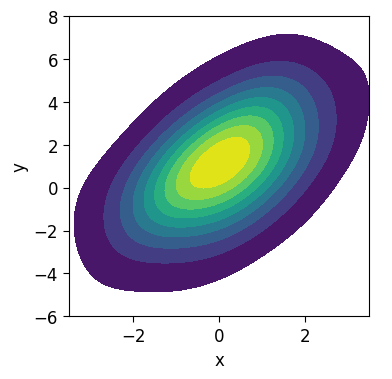

In [47]:
ax2_pymc = plot_dgp_result(dgp2_df)
ax2_pymc.savefig()

### [Question 3.3a] $\mathcal{P}_3$ as a PyMC Model

As a reminder, the graphical representation of $\mathcal{P}_3$, along with its steps, are as follows:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/824a359a5758eeaae925a3fabe213139c18008e3/2025-sum-dsan5650/dgp_3.svg" width="30%"></img>
<figcaption><i>Graphical representation of the DGP $\mathcal{P}_3$ for Part 3</i></figcaption>
</figure>
</center>

<table>
<thead>
<tr>
    <th align="center" colspan="4">The DGP $\mathcal{P}_3$ for Part 3</th>
</tr>
<tr>
    <th>Step</th>
    <th colspan="3">Operation</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$Z$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(0, 1)$</td>
</tr>
<tr>
    <td>2.</td>
    <td>$X$</td>
    <td>$\leftarrow$</td>
    <td>$Z$</td>
</tr>
<tr>
    <td>3.</td>
    <td>$Y$</td>
    <td>$\leftarrow$</td>
    <td>$Z + 1 + \sqrt{3} \cdot \varepsilon_Y$</td>
</tr>
</tbody>
</table>

where $\varepsilon_Y \sim \mathcal{N}(0, 1)$.


Implement this DGP as a PyMC model named `dgp3` in the following cell (where the code we've included at the end will display your DGP as a PGM):

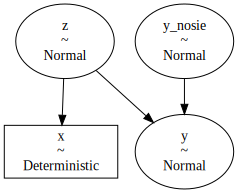

In [51]:
# @title Q3.3a-response
with pm.Model() as dgp3:
    # Your code here: implement a model linking variables named z, x, y, and
    # y_noise (for the random noise term epsilon in Step 3)
    z = pm.Normal("z", mu=0, sigma=1)
    x = pm.Deterministic("x", z)
    y_noise = pm.Normal("y_nosie", mu=0, sigma=1)
    y_mu = z + 1 + np.sqrt(3) * y_noise
    y = pm.Normal("y", mu=y_mu, sigma=0.5)
#    pass # Remove this pass statement once you've started coding your model!
    
if dgp3 is not None:
    display(pm.model_to_graphviz(dgp3))

### [Question 3.3b] Prior Predictive Distribution for $\mathcal{P}_3$

In [52]:
# @title Q3.3b-response
# Your code here: create a dgp3_idata variable containing the predictive prior
# distribution as derived from the dgp3 model from Question 3.3a
with dgp3: 
    dgp3_idata = pm.sample_prior_predictive(random_seed=1296)

# The following lines will convert your sample into a Pandas DataFrame, then
# print the first five rows (so you can check that the result looks as expected)
dgp3_df = dgp3_idata.prior.to_dataframe().reset_index().drop(columns="chain")
dgp3_df.head()

Sampling: [y, y_nosie, z]


,draw,z,x,y,y_nosie
0,0,-0.770543,-0.770543,-1.107792,-0.493629
1,1,1.928018,1.928018,0.206328,-1.467378
2,2,1.335803,1.335803,4.102690,0.871155
3,3,-1.523320,-1.523320,-3.879930,-2.091617
4,4,-0.130034,-0.130034,0.204231,-0.313369


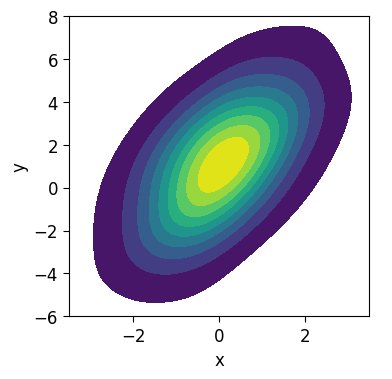

In [53]:
# @title Q3.3b-plot
ax3_pymc = plot_dgp_result(dgp3_df)
ax3_pymc.savefig()

### Side-By-Side Plots

Once you've implemented all three models in PyMC, run the following code cell to display the three joint distributions side-by-side. As in the beginning of the problem, you should find that they're nearly identical (besides some variation due to randomness).

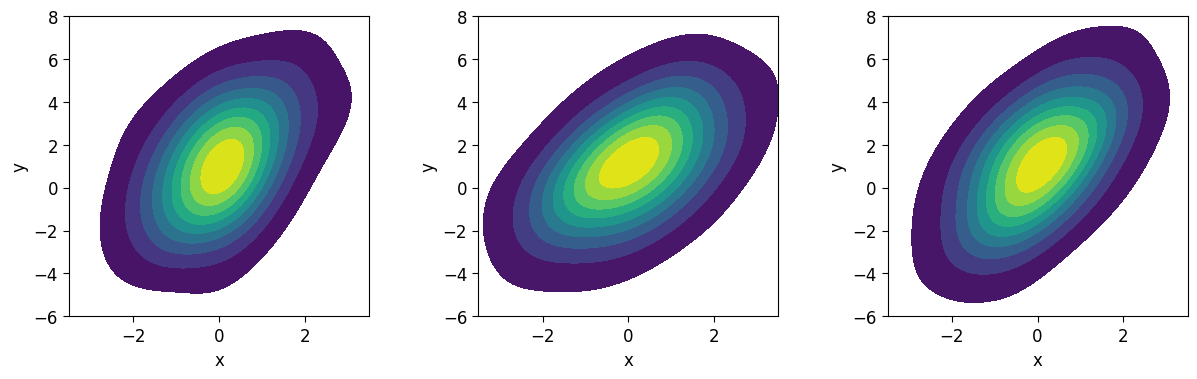

In [54]:
ax_all_pymc = ax1_pymc | ax2_pymc | ax3_pymc;
ax_all_pymc.savefig()

### [Question 3.4] Using the `do()` Operator

Now, in the following code cell, create three new models `dgp1_do`, `dgp2_do`, and `dgp3_do`, where for each you use PyMC's implementation of `do()` (imported for you at the top of the code cell) to **force** the value of `x` in each to be exactly 2.

dgp1_do:


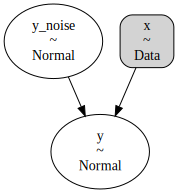

dgp2_do:


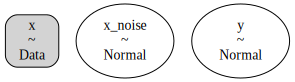

dgp3_do:


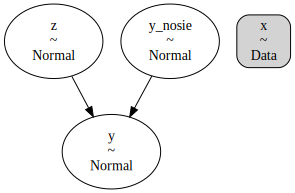

In [56]:
# @title Q3.4-response
from pymc.model.transform.conditioning import do
# DGP 1
dgp1_do = pm.do(model=dgp1, vars_to_interventions={"x": 2}) # Your code here: replace with new model using do()
if dgp1_do is not None:
    print("dgp1_do:")
    display(pm.model_to_graphviz(dgp1_do))
# DGP 2
dgp2_do = pm.do(model = dgp2, vars_to_interventions={"x": 2}) # Your code here: replace with new model using do()
if dgp2_do is not None:
    print("dgp2_do:")
    display(pm.model_to_graphviz(dgp2_do))
# DGP 3
dgp3_do = pm.do(model=dgp3, vars_to_interventions={"x": 2}) # Your code here: replace with new model using do()
if dgp3_do is not None:
    print("dgp3_do:")
    display(pm.model_to_graphviz(dgp3_do))

### [Question 3.5] The Post-`do()` Predictive Distributions

Now that you have the post-`do()` versions of each model, fill in the missing pieces of the following code cell as indicated

In [57]:
# @title Q3.5-response
# Your code here: create variables dgp1_do_idata, dgp2_do_idata, and dgp3_do_idata containing the
# prior predictive distributions for DGPs 1, 2, and 3
with dgp1_do:
    dgp1_do_idata = pm.sample_prior_predictive(random_seed=1296)
with dgp2_do:
    dgp2_do_idata = pm.sample_prior_predictive(random_seed=1296)
with dgp3_do:
    dgp3_do_idata = pm.sample_prior_predictive(random_seed=1296)

# The following lines will convert your samples into Pandas DataFrames, then
# print the first five rows for each (so you can check that the results looks as
# expected)
# dgp1_do
dgp1_do_df = dgp1_do_idata.to_dataframe().reset_index().drop(columns="chain")
dgp1_do_df['dgp'] = 1
print("dgp1_do_df:")
display(dgp1_do_df.head())
# dgp2_do
dgp2_do_df = dgp2_do_idata.to_dataframe().reset_index().drop(columns="chain")
dgp2_do_df['dgp'] = 2
print("dgp2_do_df:")
display(dgp2_do_df.head())
# dgp3_do
dgp3_do_df = dgp3_do_idata.to_dataframe().reset_index().drop(columns="chain")
dgp3_do_df['dgp'] = 3
print("dgp3_do_df:")
display(dgp3_do_df.head())

Sampling: [y, y_noise]
Sampling: [x_noise, y]
Sampling: [y, y_nosie, z]


dgp1_do_df:


,index,draw,y_noise,y,dgp
0,0,0,-0.770543,1.418566,1
1,1,1,1.928018,5.605736,1
2,2,2,1.335803,5.749257,1
3,3,3,-1.523320,-0.684276,1
4,4,4,-0.130034,2.618089,1


dgp2_do_df:


,index,draw,x_noise,y,dgp
0,0,0,-0.493629,-0.541086,2
1,1,1,-1.467378,4.856036,2
2,2,2,0.871155,3.671607,2
3,3,3,-2.091617,-2.046640,2
4,4,4,-0.313369,0.739931,2


dgp3_do_df:


,index,draw,z,y,y_nosie,dgp
0,0,0,-0.770543,-1.107792,-0.493629,3
1,1,1,1.928018,0.206328,-1.467378,3
2,2,2,1.335803,4.102690,0.871155,3
3,3,3,-1.523320,-3.879930,-2.091617,3
4,4,4,-0.130034,0.204231,-0.313369,3


Once you've derived the three prior predictive distributions, run the following final code cell to plot the three post-`do()` distributions. If it worked successfully, you should see that **$\mathcal{P}_1$ indeed has a different distribution from $\mathcal{P}_2$ and $\mathcal{P}_3$!**

,index,draw,y_noise,y,dgp,x_noise,z,y_nosie
0,0,0,-0.770543,1.418566,1,NaN,NaN,NaN
1,1,1,1.928018,5.605736,1,NaN,NaN,NaN
2,2,2,1.335803,5.749257,1,NaN,NaN,NaN
3,3,3,-1.523320,-0.684276,1,NaN,NaN,NaN
4,4,4,-0.130034,2.618089,1,NaN,NaN,NaN


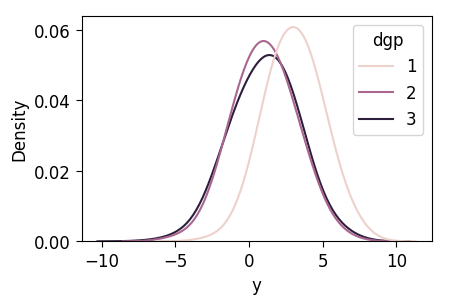

In [58]:
# @title Q3.5-plot
# Combining into a single DataFrame
dgp_all_do_df = pd.concat([dgp1_do_df, dgp2_do_df, dgp3_do_df])
display(dgp_all_do_df.head())
axo_all = pw.Brick(figsize=(3.5, 2.25));
sns.kdeplot(
    x="y", hue="dgp", data=dgp_all_do_df, ax=axo_all, bw_adjust=2
);
axo_all.savefig()

## You Did It!

Congratulations on finishing the Midterm, habibi <3 There is